In [1]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *

import matplotlib.pyplot as plt
import progressbar
import random

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=150
dims_latent = 16                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 1)
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
train_size=0.00108

Cuda installed! Running on GPU 1 GeForce RTX 2080 Ti!


# MNIST Example

In [3]:
# Datasets and dataloaders
ds = MNIST("./", download=False, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

# idx_5 = []
# for i in range(len(ds)):
#     if ds[i][1] == 5:
#         idx_5.append(i)
#         if len(idx_5) == 1:
#             break
# trainds = Subset(ds, idx_5)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


## Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...
N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 {'epoch': 0, 'train_mse_loss': 0.23053878545761108, 'train_awi2d_loss': 11.304349899291992}
 argidx T, v:  0 752


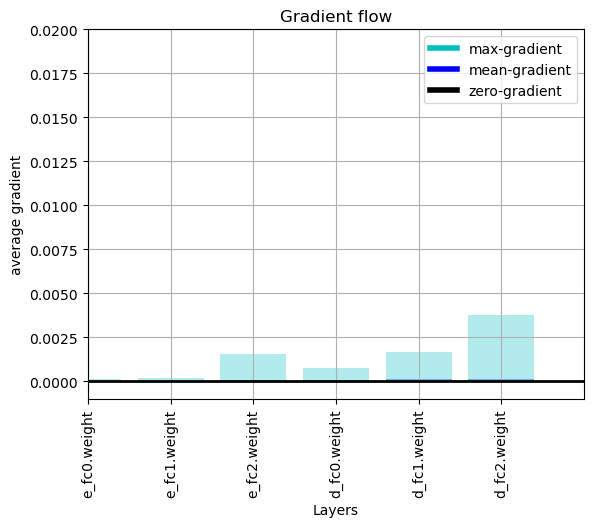

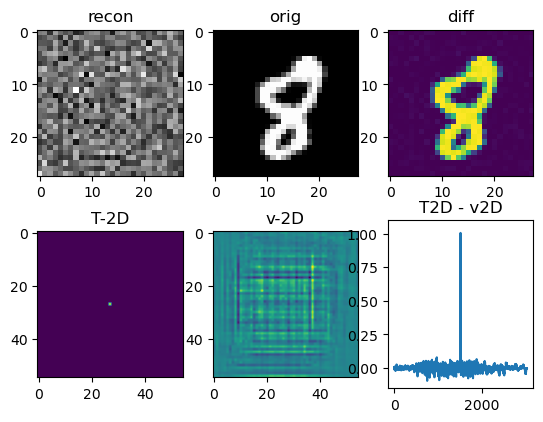

  6% (10 of 150) |#                      | Elapsed Time: 0:01:11 ETA:   0:16:42
 {'epoch': 10, 'train_mse_loss': 0.18532505631446838, 'train_awi2d_loss': 10.112560272216797}
 argidx T, v:  0 1512


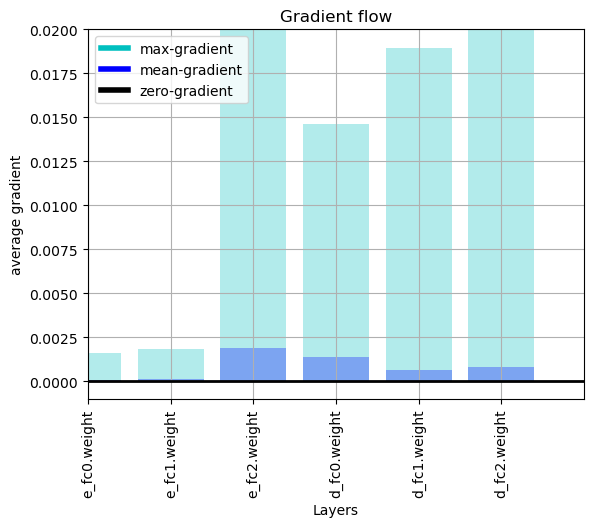

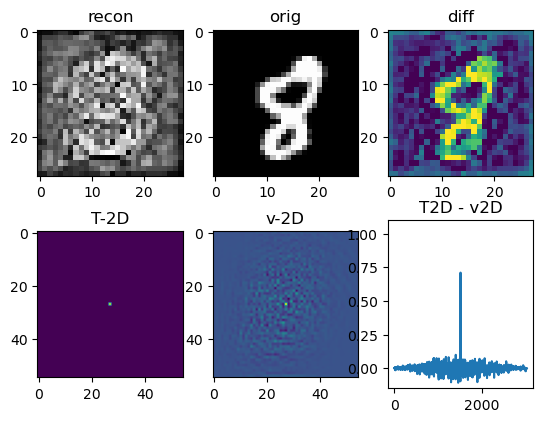

 13% (20 of 150) |###                    | Elapsed Time: 0:02:23 ETA:   0:15:17
 {'epoch': 20, 'train_mse_loss': 0.11150367558002472, 'train_awi2d_loss': 8.351436614990234}
 argidx T, v:  0 1512


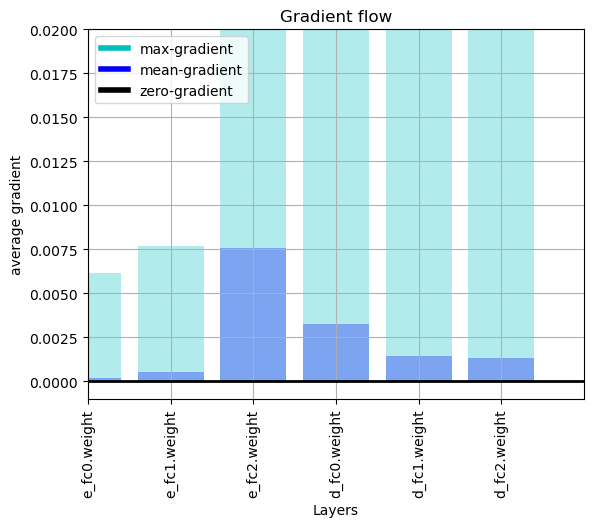

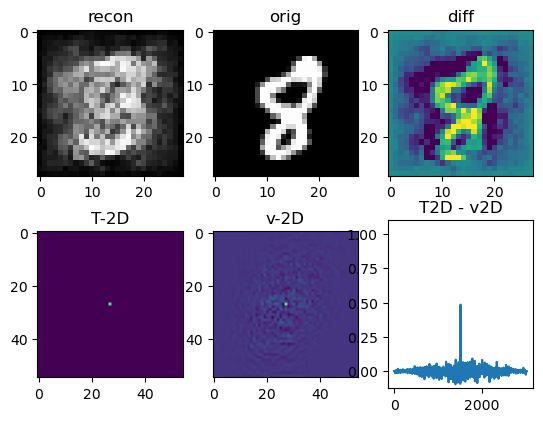

 20% (30 of 150) |####                   | Elapsed Time: 0:03:35 ETA:   0:14:07
 {'epoch': 30, 'train_mse_loss': 0.07155520468950272, 'train_awi2d_loss': 6.211846351623535}
 argidx T, v:  0 1512


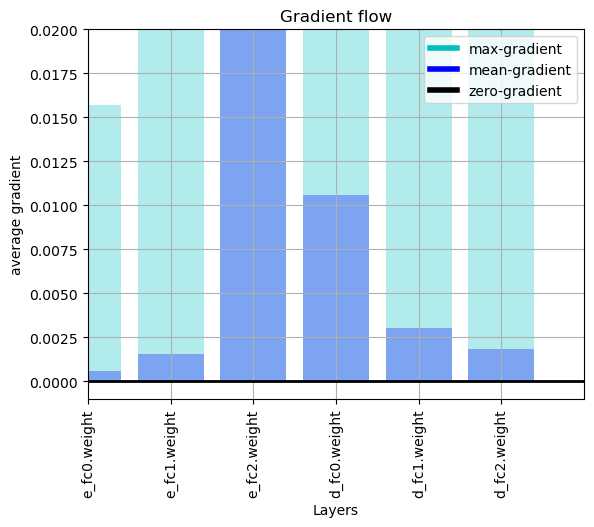

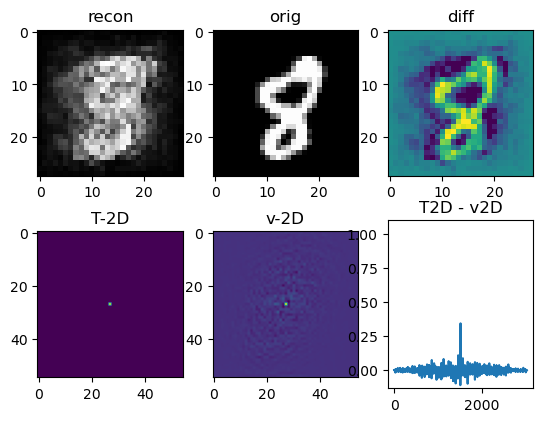

 26% (40 of 150) |######                 | Elapsed Time: 0:04:47 ETA:   0:13:02
 {'epoch': 40, 'train_mse_loss': 0.04415406286716461, 'train_awi2d_loss': 4.340634346008301}
 argidx T, v:  0 1512


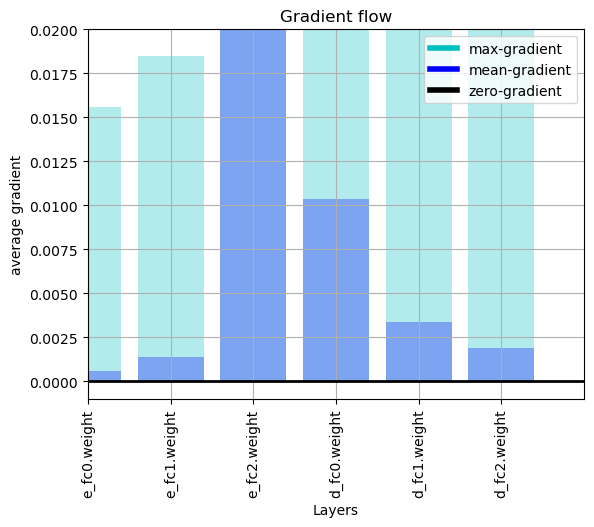

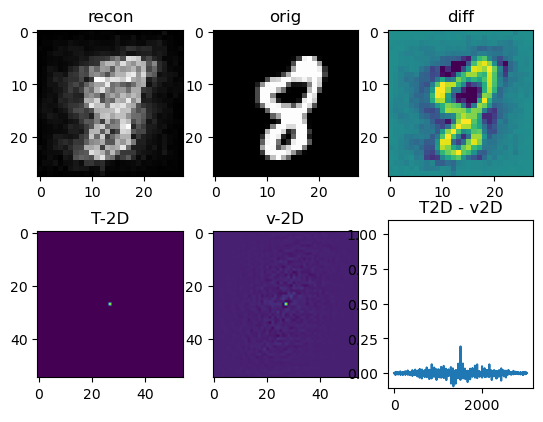

 33% (50 of 150) |#######                | Elapsed Time: 0:06:00 ETA:   0:11:48
 {'epoch': 50, 'train_mse_loss': 0.027800748124718666, 'train_awi2d_loss': 3.5308172702789307}
 argidx T, v:  0 1512


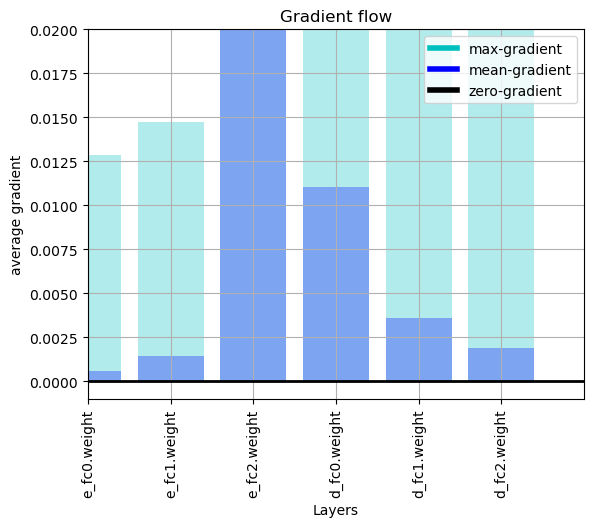

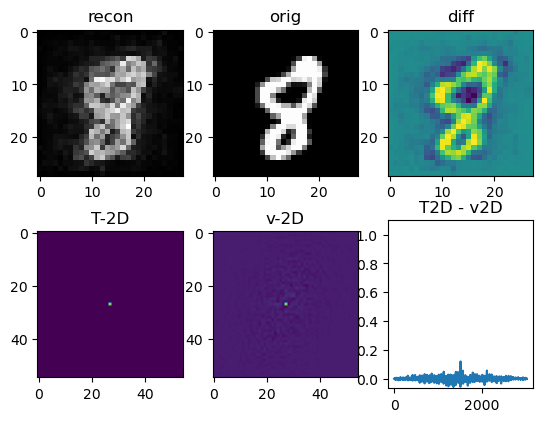

 40% (60 of 150) |#########              | Elapsed Time: 0:07:12 ETA:   0:10:55
 {'epoch': 60, 'train_mse_loss': 0.018167022615671158, 'train_awi2d_loss': 2.9589898586273193}
 argidx T, v:  0 1512


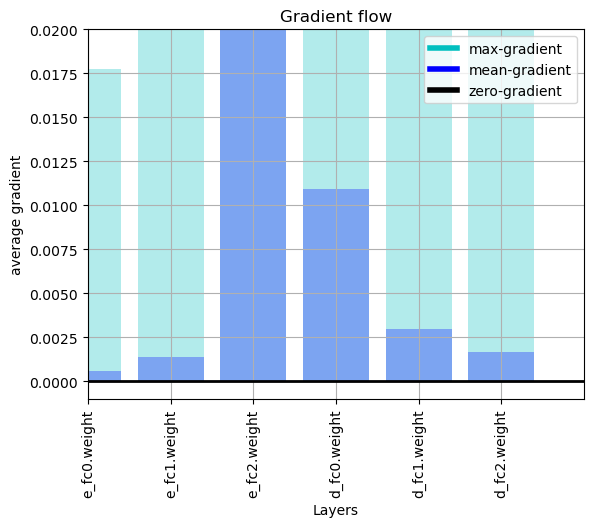

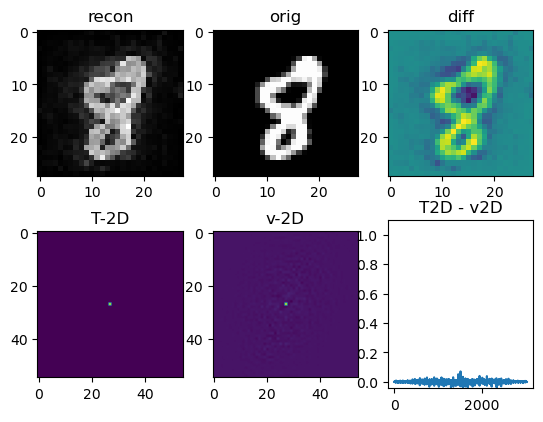

 46% (70 of 150) |##########             | Elapsed Time: 0:08:24 ETA:   0:09:30
 {'epoch': 70, 'train_mse_loss': 0.013015653938055038, 'train_awi2d_loss': 2.6349945068359375}
 argidx T, v:  0 1512


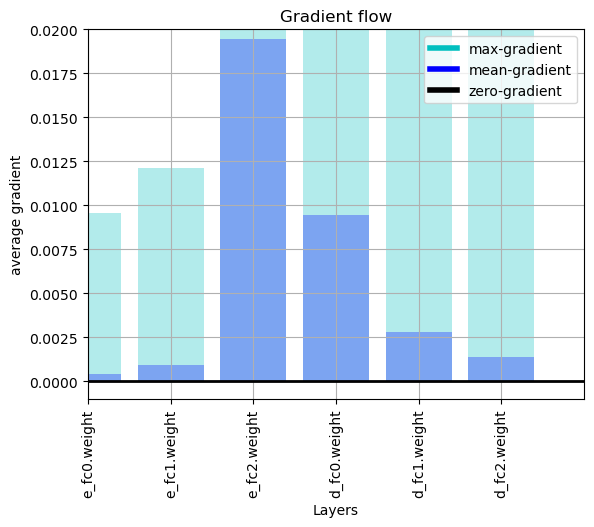

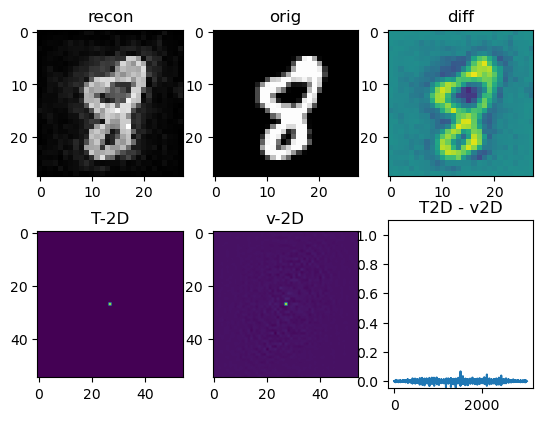

 53% (80 of 150) |############           | Elapsed Time: 0:09:38 ETA:   0:08:25
 {'epoch': 80, 'train_mse_loss': 0.010490396060049534, 'train_awi2d_loss': 2.539543628692627}
 argidx T, v:  0 1512


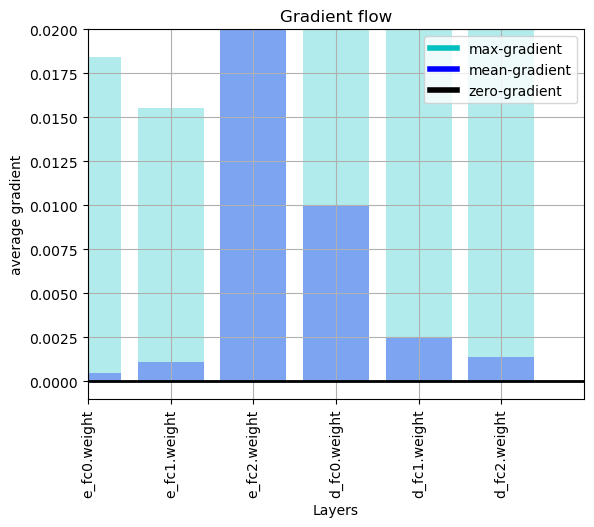

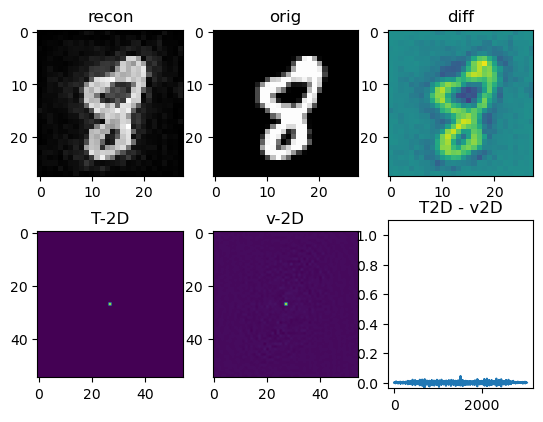

 60% (90 of 150) |#############          | Elapsed Time: 0:10:50 ETA:   0:06:59
 {'epoch': 90, 'train_mse_loss': 0.007887052372097969, 'train_awi2d_loss': 2.307842969894409}
 argidx T, v:  0 1512


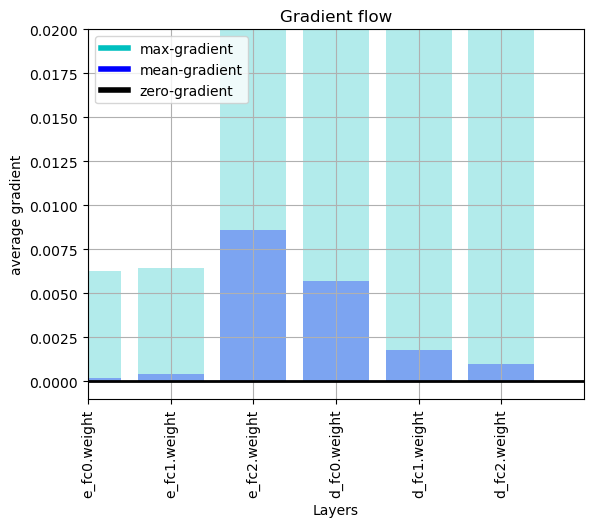

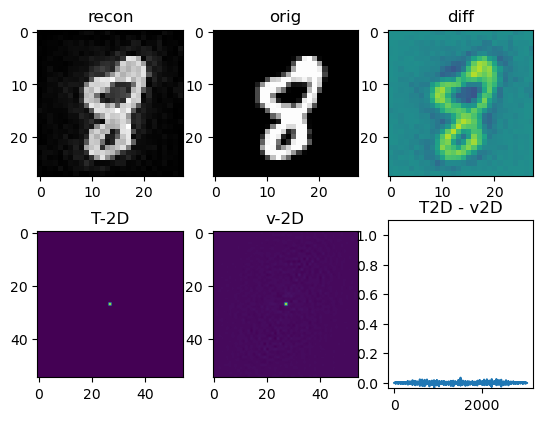

 66% (100 of 150) |##############        | Elapsed Time: 0:12:01 ETA:   0:05:53
 {'epoch': 100, 'train_mse_loss': 0.007314133923500776, 'train_awi2d_loss': 2.271709680557251}
 argidx T, v:  0 1512


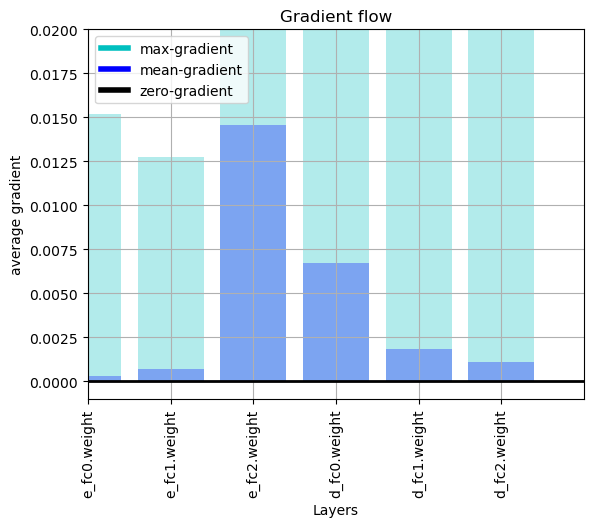

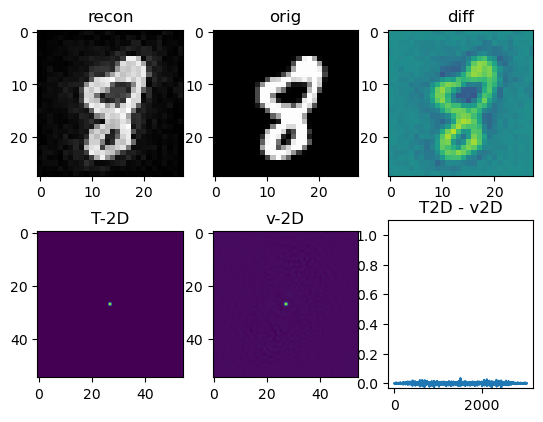

 73% (110 of 150) |################      | Elapsed Time: 0:13:15 ETA:   0:04:42
 {'epoch': 110, 'train_mse_loss': 0.006731601897627115, 'train_awi2d_loss': 2.241490364074707}
 argidx T, v:  0 1512


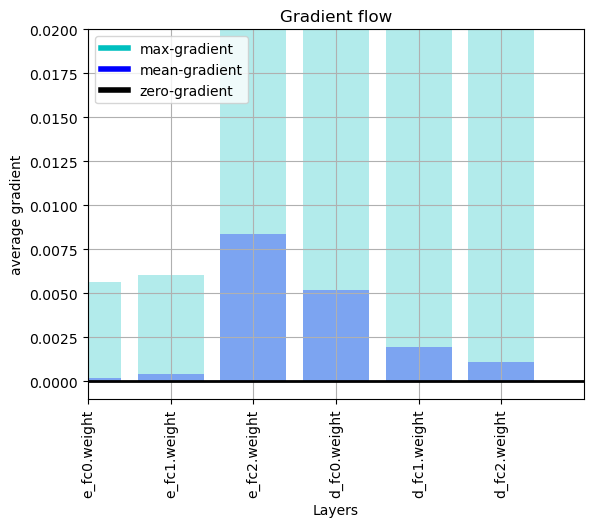

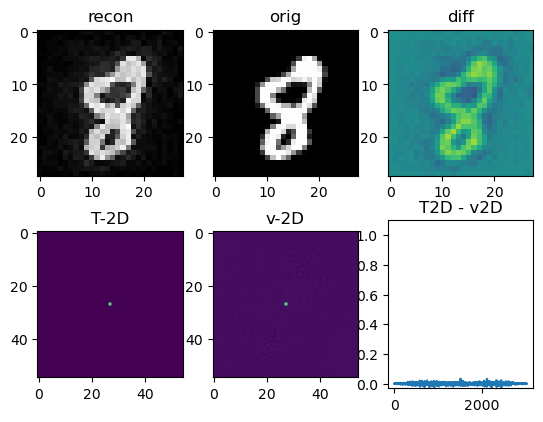

 80% (120 of 150) |#################     | Elapsed Time: 0:14:28 ETA:   0:03:30
 {'epoch': 120, 'train_mse_loss': 0.006156555376946926, 'train_awi2d_loss': 2.180816411972046}
 argidx T, v:  0 1512


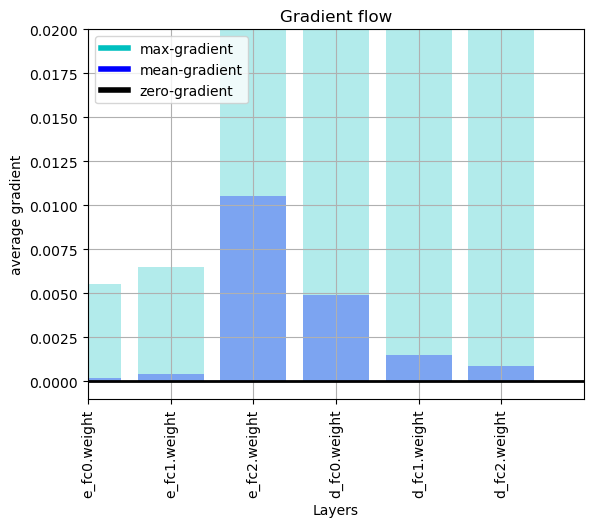

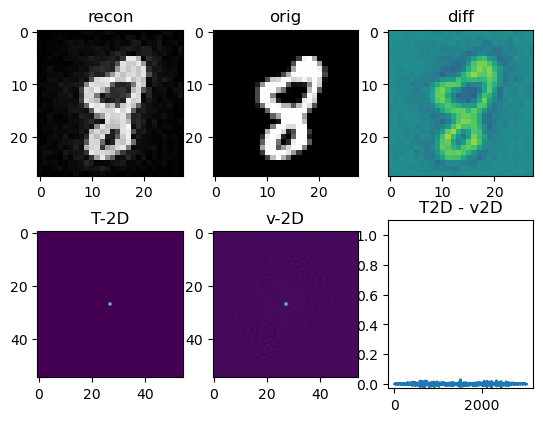

 86% (130 of 150) |###################   | Elapsed Time: 0:15:41 ETA:   0:02:25
 {'epoch': 130, 'train_mse_loss': 0.0057504670694470406, 'train_awi2d_loss': 2.1445722579956055}
 argidx T, v:  0 1512


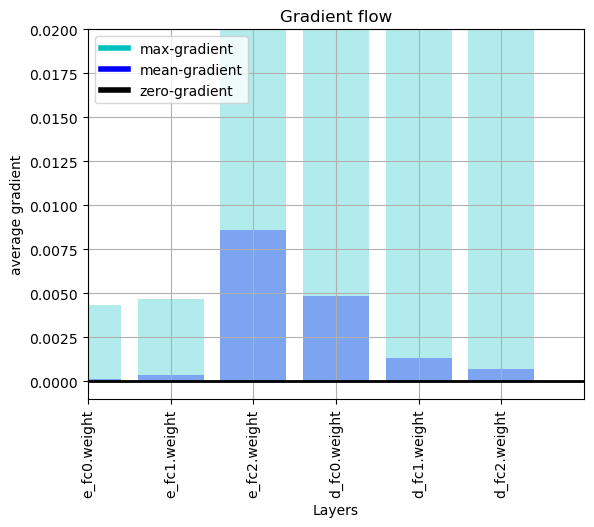

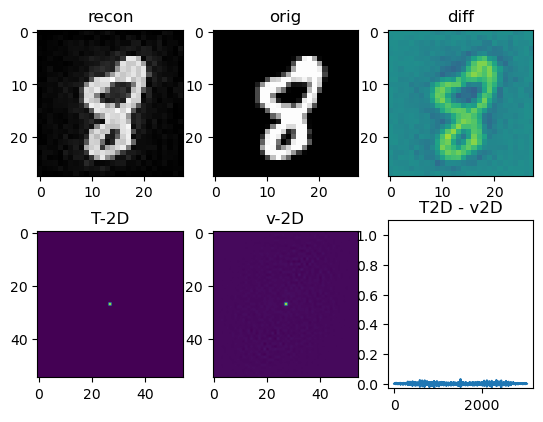

 93% (140 of 150) |####################  | Elapsed Time: 0:16:53 ETA:   0:01:11
 {'epoch': 140, 'train_mse_loss': 0.005217303521931171, 'train_awi2d_loss': 2.19114351272583}
 argidx T, v:  0 1512


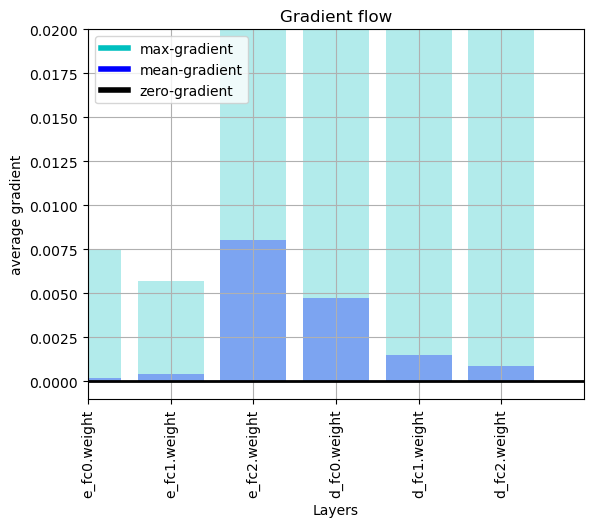

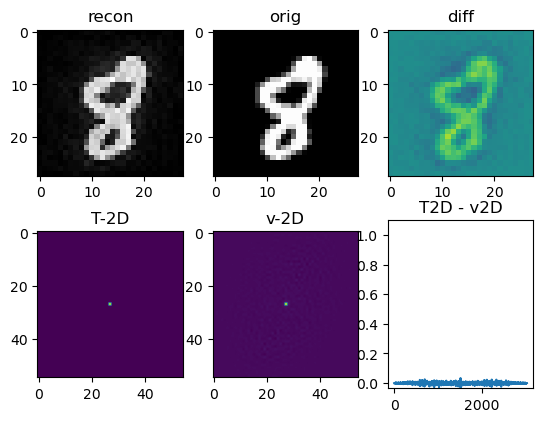

 99% (149 of 150) |##################### | Elapsed Time: 0:18:00 ETA:   0:00:07
 {'epoch': 149, 'train_mse_loss': 0.005377094727009535, 'train_awi2d_loss': 2.1595687866210938}
 argidx T, v:  0 1512


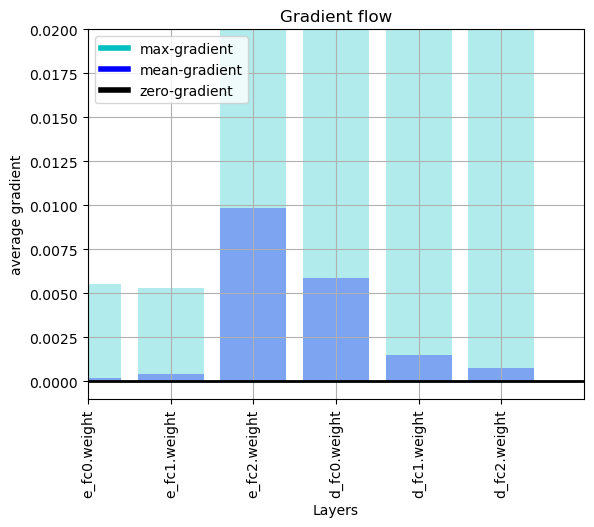

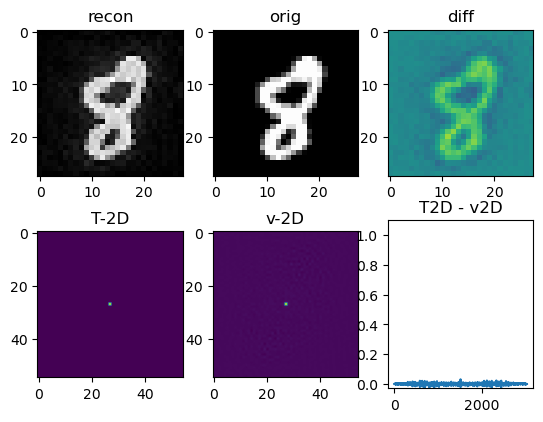

100% (150 of 150) |######################| Elapsed Time: 0:18:01 Time:  0:18:01


In [4]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi2D     = AWLoss2D(reduction="sum", std=1e-4, store_filters=False, alpha=0.02)
awi2D_val = AWLoss2D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        if epoch < switch_at_epoch:
            epoch_loss = train_ae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss = train_ae(model, train_loader, optimizer, awi2D, device=device)
            
        epoch_mse = validate_ae(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse_loss":epoch_mse.item(), "train_awi2d_loss": epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon = model(X)
            
            f = awi2D_val(recon, X)
            v, T = awi2D_val.v_all[0], awi2D_val.T_arr

            print("\n", log)
            print(" argidx T, v: ",torch.argmin(T).item(), torch.argmax(torch.abs(v)).item())

            plot_grad_flow(model.named_parameters())

            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
            axs[0, 2].set_title("diff")

            axs[1, 0].imshow(T.detach().cpu().numpy())
            axs[1, 0].set_title("T-2D")

            axs[1, 1].imshow(v.detach().cpu().numpy())
            axs[1, 1].set_title("v-2D")

            axs[1, 2].plot((T.flatten() - v.flatten()).detach().cpu().numpy())
            axs[1, 2].set_ylim(None, 1.1)
            axs[1, 2].set_title("T2D - v2D")

            plt.show()


## Variational Autoencoder

In [47]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi2D     = AWLoss2D(reduction="sum", std=1e-4, return_filters=False)
awi2D_val = AWLoss2D(reduction="sum", std=1e-4, return_filters=True)
switch_at_epoch = 10 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        if epoch < switch_at_epoch:
            epoch_loss, epoch_mse, epoch_kl = train_vae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss, epoch_mse, epoch_kl = train_vae(model, train_loader, optimizer, awi2D, device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse_loss":epoch_mse.item(), "train_awi2d_loss": epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon, _, _ = model(X)
            
            _, v, T = awi2D_val(recon, X)
            v = v[0]

            print("\n", log)
            print(" argidx T, v: ",torch.argmin(T).item(), torch.argmax(torch.abs(v)).item())
            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            axs[1, 0].imshow(T.detach().cpu().numpy())
            axs[1, 0].set_title("T-2D")

            axs[1, 1].imshow(v.detach().cpu().numpy())
            axs[1, 1].set_title("v-2D")

            axs[1, 2].plot((T.flatten()*v.flatten()).detach().cpu().numpy())
            axs[1, 2].set_title("T2D * v2D")

            plt.show()

ValueError: InstanceNorm1d returns 0-filled tensor to 2D tensor.This is because InstanceNorm1d reshapes inputs to(1, N * C, ...) from (N, C,...) and this makesvariances 0.